# Laboratorium 9. Wizja Komputerowa

**Uwaga:** Poniższy notebook jest stworzony z myślą o odpalaniu go w [Colaboratory](https://colab.research.google.com/), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [20]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose , Lambda
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [21]:
torch.cuda.is_available()

True

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


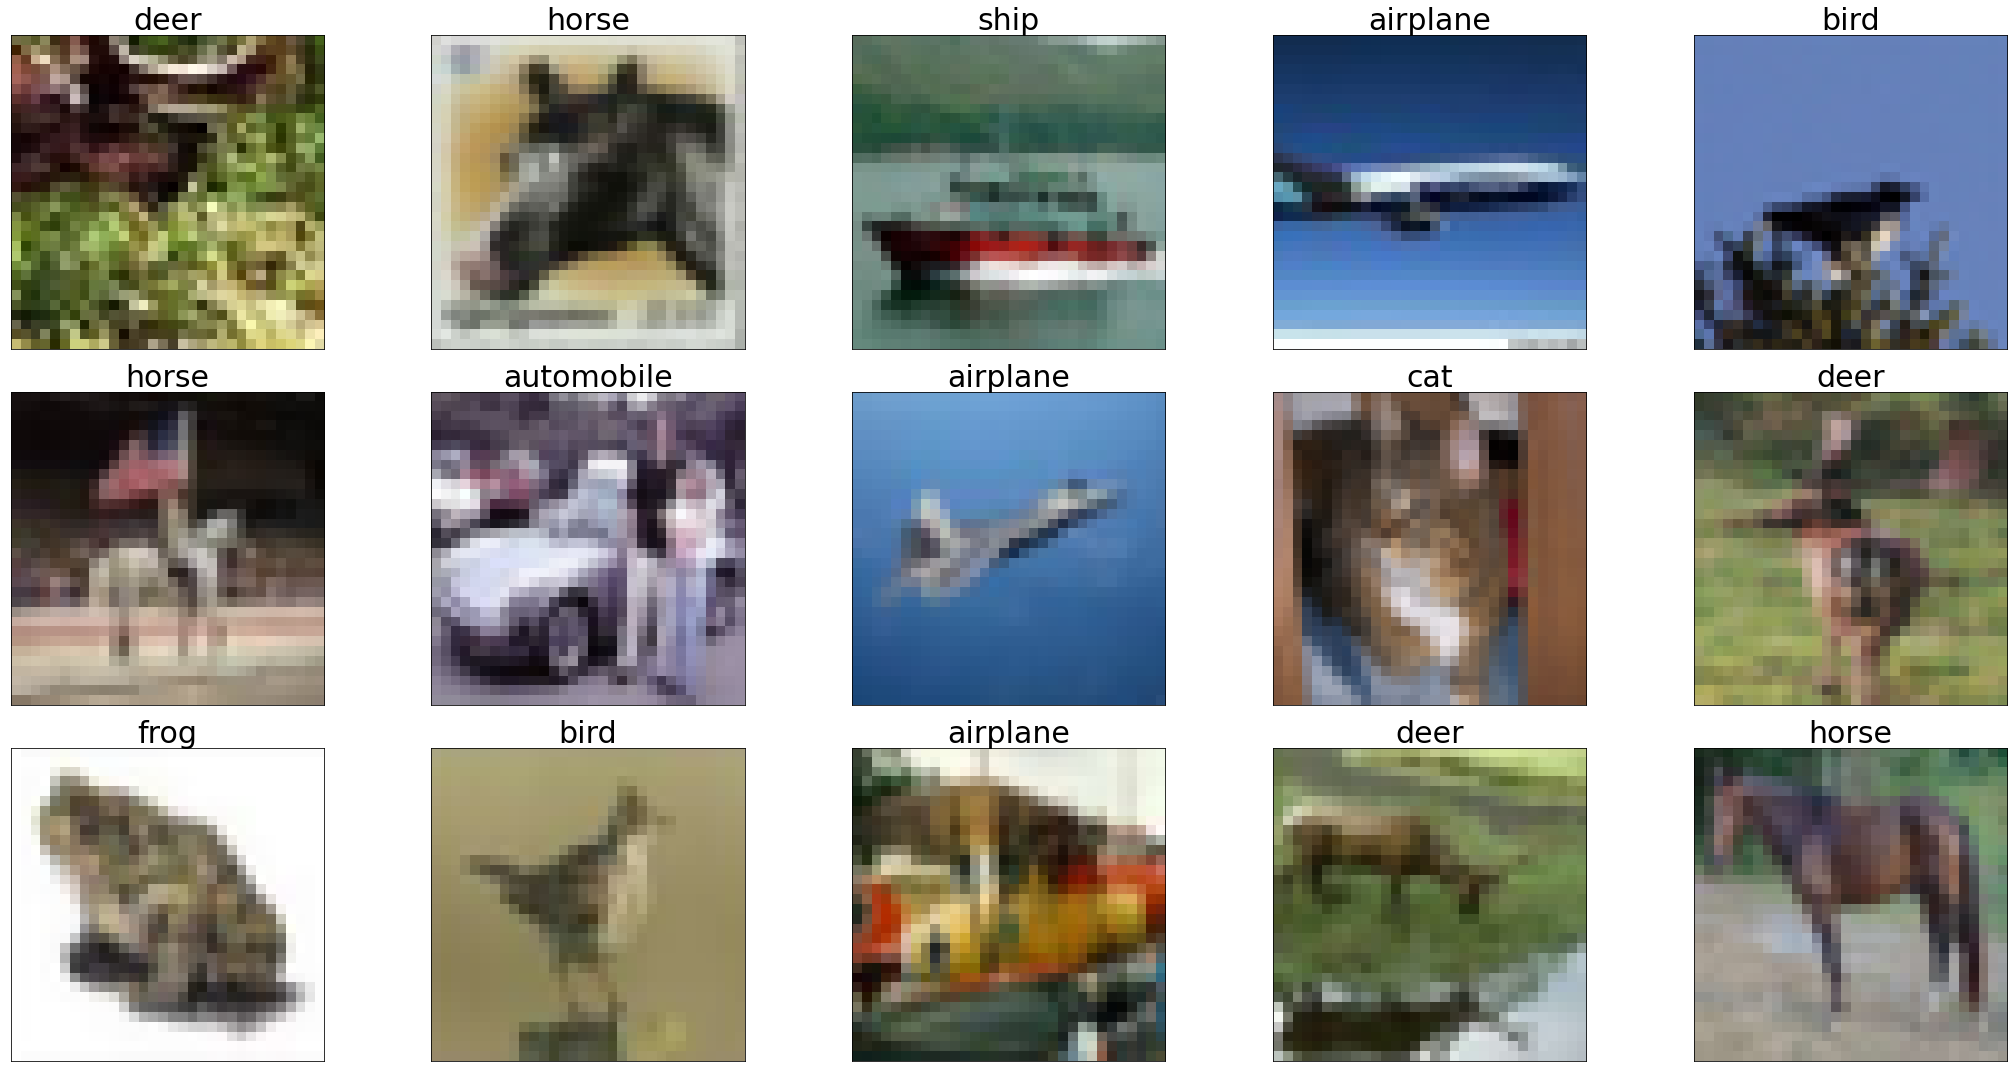

In [ ]:
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [86]:
# tutaj zdefiniuj swój model, nie zapomnij podziedziczyć po torch.nn.Module


class myNeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.network=torch.nn.Sequential(
        torch.nn.Conv2d(3,10,kernel_size=3,padding=1),
        torch.nn.ReLU(), # 10 x 32 x 32
        torch.nn.BatchNorm2d(10),

        torch.nn.Conv2d(10,30,kernel_size=3,stride=1,padding=1),
        torch.nn.ReLU(), # 30 x 32 x 32
        torch.nn.MaxPool2d(2,2),
        torch.nn.BatchNorm2d(30), #30 x 16 x 16

        torch.nn.Conv2d(30,60,kernel_size=3,stride=1,padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2), 
        torch.nn.BatchNorm2d(60), #60 x 8 x 8


        torch.nn.Flatten(),
        torch.nn.Linear(60*8*8,240),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(240,120),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(120,60),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(60,10)

      )
  def forward(self,x):
    return self.network(x)

In [ ]:
trainset = CIFAR10(
    root='.',
    download=True,
    train=True, 
    transform=Compose([ToTensor()])
    )


Files already downloaded and verified


In [88]:
# tutaj uzupełnij ładowanie danych treningowych i testowych

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=Compose([ToTensor(),Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])) 

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=Compose([ToTensor(),Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))


train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [89]:

# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami
my_model=myNeuralNetwork()

device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
my_model.to(device)

epoch=18 #po okolo 15-18 epokach model sie overfittowal, stad 18 epok
loss_fn=torch.nn.CrossEntropyLoss()
history_train_loss=[]
history_train_acc=[]
history_test_loss=[]
history_test_acc=[]
optimizer=torch.optim.Adam(my_model.parameters(),lr=0.005)

#petla uczenia 
for e in range(1,epoch+1):
  my_model.train()
  train_losses=[]
  train_acc=[]

  running_loss=0
  train_correct=0
  train_size=0
  for i,data in enumerate(train_loader):

    inputs,labels=data[0].to(device),data[1].to(device)

    outputs=my_model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss+=loss.item()
    
    _, preds = torch.max(outputs,dim=1)
    train_correct+=torch.sum(preds==labels).item()
    train_size+=len(data[1])

  train_loss=running_loss/len(train_loader)
  train_acc=train_correct/train_size

  history_train_acc.append(train_acc)
  history_train_loss.append(train_loss)

  print("Epoch:"+str(e)+" Loss: "+str(train_loss)+" Accuracy: "+str(train_acc))
  
  my_model.eval()
  with torch.no_grad():    
    running_test_acc=[]
    running_test_loss=0
    test_correct=0
    test_size=0
    for i, data in enumerate(test_loader):
      input,label=data[0].to(device),data[1].to(device)
      output=my_model(input)

      test_loss=loss_fn(output,label)
      running_test_loss+=test_loss.item()
      _, pred = torch.max(output,dim=1)
      test_correct+=torch.sum(pred==label).item()
      test_size += len(data[1])

    loss1=running_test_loss/len(test_loader)
    acc1=test_correct/test_size
    print("Test loss: "+str(loss1) +' Accuracy: ' + str(acc1))

    history_test_acc.append(acc1)
    history_test_loss.append(loss1)
    



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:1 Loss: 1.712819509360255 Accuracy: 0.36986
Test loss: 1.2869852781295776 Accuracy: 0.5531
Epoch:2 Loss: 1.3485144157798923 Accuracy: 0.52974
Test loss: 1.0862574934959413 Accuracy: 0.6322
Epoch:3 Loss: 1.1688797668534883 Accuracy: 0.60726
Test loss: 0.9755341798067093 Accuracy: 0.6798
Epoch:4 Loss: 1.057494420786293 Accuracy: 0.65078
Test loss: 0.9181896597146988 Accuracy: 0.7003
Epoch:5 Loss: 0.9728264176115697 Accuracy: 0.68148
Test loss: 0.8700567215681076 Accuracy: 0.7042
Epoch:6 Loss: 0.8866066792789771 Accuracy: 0.70874
Test loss: 0.8545039504766464 Accuracy: 0.7223
Epoch:7 Loss: 0.8278547951153347 Accuracy: 0.73146
Test loss: 0.8212828427553177 Accuracy: 0.7317
Epoch:8 Loss: 0.7809498930463985 Accuracy: 0.74812
Test loss: 0.7910597264766693 Accuracy: 0.7432
Epoch:9 Loss: 0.7383905387654597 Accuracy: 0.76256
Test loss: 0.7745338588953018 Accuracy: 0.7481
Epoch:10 Loss: 0.6875811949068186 Accuracy: 0.78036
Test loss: 0.8084027677774429 Accuracy: 0.7527
Epoch:11 Loss: 0.6543

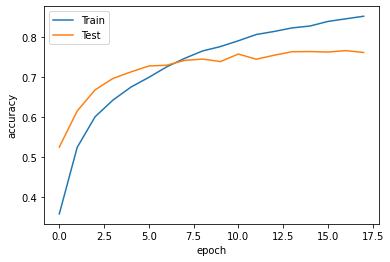

In [ ]:
plt.plot(history_train_acc)
plt.plot(history_test_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
 
plt.show()

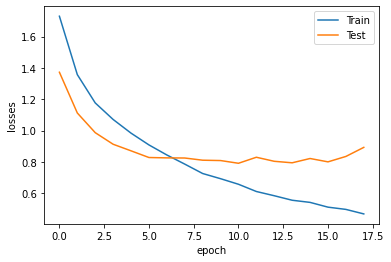

In [ ]:
plt.plot(history_train_loss)
plt.plot(history_test_loss)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
 
plt.show()

## Augmentacje

Pakiet `torchvision` implementuje wiele różnych transformacji do danych, część z nich jest użyteczna do tzw. augmentacji danych. Augmentacja danych to mechanizm "sztucznego" zwiększania datasetu treningowego poprzez dodawanie do niego zmodyfikowanych kopii danych, które już w nim istnieją. Augmentacja jest szczególnie użyteczna kiedy nasz dataset ma małą liczbę przykładów do uczenia skomplikowanych sieci neuronowych. 

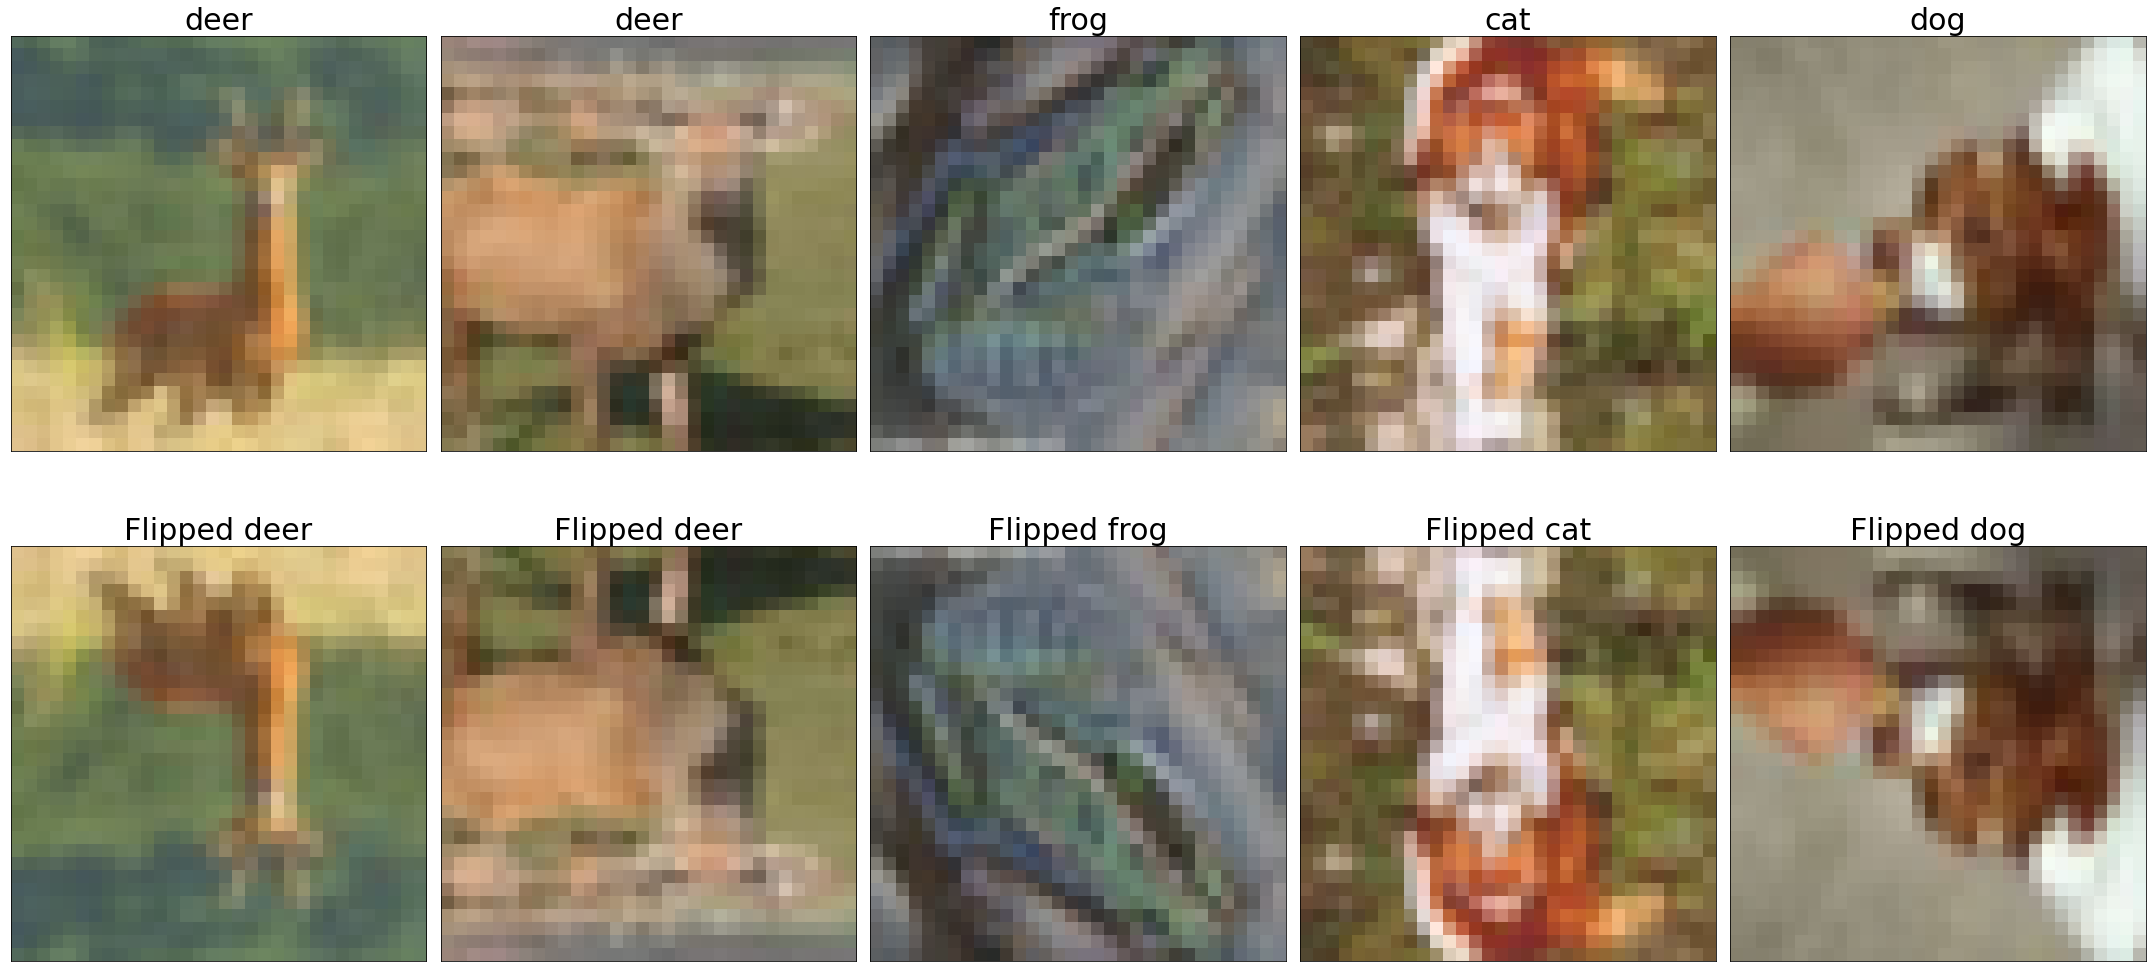

In [ ]:
from torchvision.transforms import RandomVerticalFlip

# load test set
dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1) 

# load some data
for x, y in loader:
    break
    

# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])
    
for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [24]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe
from torchvision.transforms import RandomVerticalFlip, RandomCrop

augment=Compose([RandomVerticalFlip()])#,RandomCrop(32,padding=4)])
normalize=Compose([ToTensor(),Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=Compose([augment,normalize]))

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=normalize)


train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [27]:
# tutaj powtórz pętle uczenia z poprzedniego zadania


# model=myNeuralNetwork() #wykomentowane, ponieważ douczałem model, dlatego nie deklarowałem go ponownie

device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.to(device)

epoch=20
loss_fn=torch.nn.CrossEntropyLoss()
history_train_loss=[]
history_train_acc=[]
history_test_loss=[]
history_test_acc=[]
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

#petla uczenia 
for e in range(1,epoch+1):
  model.train()
  train_losses=[]
  train_acc=[]

  running_loss=0
  train_correct=0
  train_size=0
  for i,data in enumerate(train_loader):

    inputs,labels=data[0].to(device),data[1].to(device)

    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss+=loss.item()
    
    _, preds = torch.max(outputs,dim=1)
    train_correct+=torch.sum(preds==labels).item()
    train_size+=len(data[1])
  scheduler.step()
  train_loss=running_loss/len(train_loader)
  train_acc=train_correct/train_size

  history_train_acc.append(train_acc)
  history_train_loss.append(train_loss)

  print("Epoch:"+str(e)+" Loss: "+str(train_loss)+" Accuracy: "+str(train_acc))
  
  model.eval()
  with torch.no_grad():    
    running_test_acc=[]
    running_test_loss=0
    test_correct=0
    test_size=0
    for i, data in enumerate(test_loader):
      input,label=data[0].to(device),data[1].to(device)
      output=model(input)

      test_loss=loss_fn(output,label)
      running_test_loss+=test_loss.item()
      _, pred = torch.max(output,dim=1)
      test_correct+=torch.sum(pred==label).item()
      test_size += len(data[1])

    loss1=running_test_loss/len(test_loader)
    acc1=test_correct/test_size
    print("Test loss: "+str(loss1) +' Accuracy: ' + str(acc1))

    history_test_acc.append(acc1)
    history_test_loss.append(loss1)
    



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch:1 Loss: 0.4176059267958816 Accuracy: 0.85904
Test loss: 1.0791259437799454 Accuracy: 0.7401
Epoch:2 Loss: 0.4110983388156307 Accuracy: 0.8596
Test loss: 1.098922500014305 Accuracy: 0.741
Epoch:3 Loss: 0.40995338163813766 Accuracy: 0.86108
Test loss: 1.107575809955597 Accuracy: 0.7387
Epoch:4 Loss: 0.4092397528643511 Accuracy: 0.86234
Test loss: 1.1028277724981308 Accuracy: 0.7383
Epoch:5 Loss: 0.40322839605564975 Accuracy: 0.86416
Test loss: 1.0977146625518799 Accuracy: 0.7379
Epoch:6 Loss: 0.40006174998623983 Accuracy: 0.86598
Test loss: 1.1101319402456284 Accuracy: 0.7376
Epoch:7 Loss: 0.3964003993540394 Accuracy: 0.86584
Test loss: 1.128154256939888 Accuracy: 0.7373
Epoch:8 Loss: 0.3874036830906965 Accuracy: 0.86824
Test loss: 1.1258179545402527 Accuracy: 0.7399
Epoch:9 Loss: 0.3890949676231462 Accuracy: 0.8701
Test loss: 1.1246823430061341 Accuracy: 0.7379
Epoch:10 Loss: 0.38558750249901597 Accuracy: 0.86902
Test loss: 1.1551518470048905 Accuracy: 0.7358
Epoch:11 Loss: 0.3815

In [ ]:
# Niestety pomimo prób nie udało mi się poprawić wyniku z poprzedniego zadania,
# nawet przy 90 epokach i tylko RandomVerticalFlip.
# Maksymalny wynik na tescie jaki otrzymałem to 74,18%, bez RandomCrop(),
# Z RandomCrop wyniki były gorsze (maksymalnie 71% na tescie przy 70 epokach).
# Być może przy większej ilości epok wynik by się jednak poprawił (?) 
# dodałem również LR_scheduler co polepszyło uczenie, ale nie wystarczyło by poprawić wynik

# Wydaje mi się że największy wpływ ma architektóra, która przy BatchNorm2d oraz RandomCropie
# daje wyniki które są trudne do przewidzenia, a przynajmniej taka jest moja hipoteza. 
# Mogłem również spróbowac użyć większej ilości neuronów, lub więcej warstw konwolucyjnych,
# niestety nie starczyło mi na to czasu, dlatego zostawiam to w tym momencie w takiej, niedokończonej formie.


## Ataki Adwersarialne

Jednym z (ciągle nierozwiązanych) problemów w sieciach neuronowych, zwłaszcza systemów wizyjnych są tzw. ataki adwersarialne. Przy takim ataku, "agresor" ma pewien ograniczony dostęp do modelu (np. dostęp do logitów na wyjściu sieci) i używając tych informacji jest w stanie tak zmodyfikować wejście do sieci w takim sposób aby uzyskać błędne, a nawet specyficzne, wyjście. Poniższy kod prezentuje metodę **F**ast **G**radient **S**ign **M**ethod, która modyfikuje wejście do sieci za pomocą gradientu funkcji kosztu po tym wejściu.

<font size=4>$$ \hat{x} = x + \epsilon \space \textit{sign}\big(\nabla_x \mathcal{L}(x, y)\big) $$ </font>

In [28]:
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor
import torch.nn as nn
import numpy as np

from PIL import Image
import urllib.request
import io
import json 

In [29]:
# cast to tensor and resize to for inception v3
preprocess = Compose([Resize((299,299)), ToTensor()])

# some prepared images
img_names = ['bird.jpg', 'cat.jpg', 'dog.jpg', 'frog.jpg']
imgs_url = 'https://raw.githubusercontent.com/gmum/ml2021-22/master/lab/resources/'

# get images 
imgs = []
for img_name in img_names:
    url = imgs_url + '/' + img_name
    with urllib.request.urlopen(url) as u:
        f = io.BytesIO(u.read())

    img = preprocess(Image.open(f))
    imgs.append(img)
    
imgs = torch.stack(imgs)

# get ImageNet classes list
labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(labels_url) as url:
    s = url.read().decode("utf-8")
    labels = json.loads(s)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

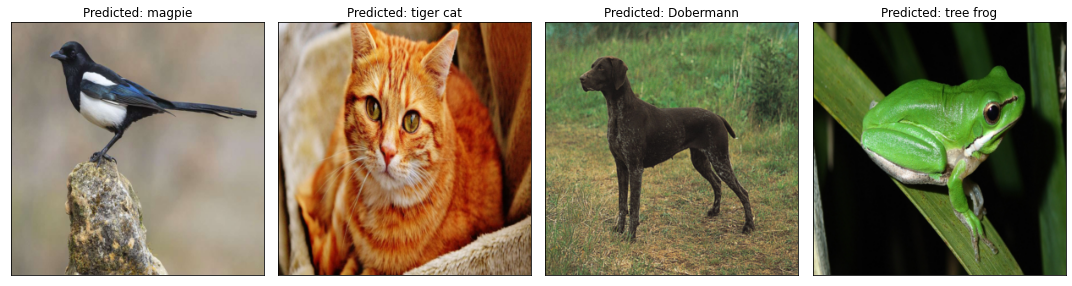

In [30]:
# load inception model 
model = inception_v3(pretrained=True) 
# set to eval, we don't want to modify it
model.eval()

# run the images through the model
output = model(imgs)
pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, imgs, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {labels[p]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [59]:
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.19

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

In [60]:
# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

### Zadanie 3. Przykłady Adwersarialne (2 pkt.)
1. Zobacz dla jakiego $\epsilon$ metoda FGSM zmieni predykcje dla Sroki z powyższego przykładu.
2. Zastosuj metodę FGSM dla swojego modelu i 4 losowych przykładów z CIFAR10 tak aby uzyskać wizualizacje podobną do powyższej.

`HINT`: Normalizacja, której normalnie używamy sprawia, że obrazki wychodzą poza typowe $[0, 1]$, można rozwiązać ten problem na dwa sposoby: <br> 1) "odwrócić" normalizację znając użyte średnią i odchylenie standardowe, <br> 2) nie używać normalizacji

In [ ]:
#dla eps > 0.19 predykcja Sroki jest niepoprawna

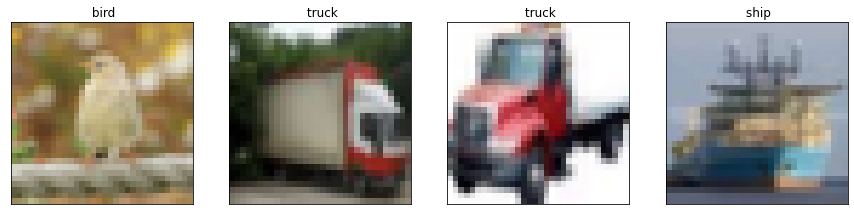

In [174]:
# tutaj załaduj 4 losowe przykłady ze zbioru testowego, uważaj na normalizacje!


dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=4, shuffle=True)

for x, y in loader:
    break


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img,label in zip(axes, x, y ):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f" {dataset.classes[label]}")
    ax.set_xticks([])
    ax.set_yticks([])
    

In [175]:
x_data=normalize(x) #normalizuje x, poniewaz model jest nauczony na danych znormalizowanych

In [176]:
# tutaj zastosuj metode FGSM do wygenerowania przykładów adwersarialnych
my_model.eval()

x_data=x_data.to(device)

output = my_model(x_data)
pred = torch.argmax(output, 1)
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.06

# inputs need to have gradients enabled!
x_data.requires_grad = True

# run the model and calculate the loss
outputs = my_model(x_data)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, x_data, create_graph=False)[0]

# FGSM 
adv_imgs = x_data + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
adv_imgs=normalize(adv_imgs) #normalizuje adv_imgs, aby pasowaly do wejscia do modelu

# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

avd_imgs=adv_imgs.to(device)
grads=grads.to(device)

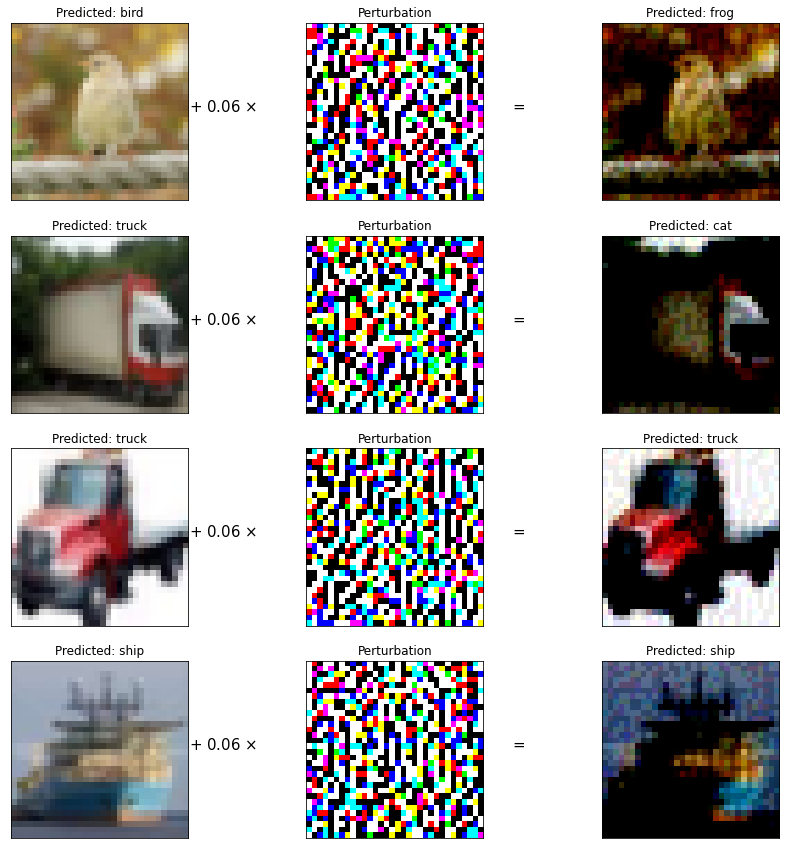

In [177]:
# tutaj przetestuj swój model i użyj wizualizacji z powyższego przykładu
from torch import Tensor

output = my_model(adv_imgs)
adv_pred = torch.argmax(output, 1)


mean = torch.tensor([0.5,0.5,0.5])
std = torch.tensor([0.5, 0.5, 0.5])

x_data=Tensor.cpu(x_data)
x_data = x_data * std[:, None, None] + mean[:, None, None] # "odwracam" normalizacje na x_data

adv_imgs = Tensor.cpu(adv_imgs)
adv_imgs= adv_imgs * std[:, None, None] + mean[:, None, None] #odwracam normalizacje na adv_imgs, chociaz wydaje mi sie ze daje to niepoprawne obrazki
# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, x_data, adv_imgs, pred, adv_pred, grads):
    img=Tensor.cpu(img)
    row[0].imshow((np.transpose(img.detach(), (1,2,0))))
    row[0].set_title(f"Predicted: {dataset.classes[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    g=Tensor.cpu(g)
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    adv=Tensor.cpu(adv)
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {dataset.classes[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
# fig.tight_layout()